In [2]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, ttest_ind

# 1. Load and Preprocess Data
def preprocess_data(file_path, sheet_name=0):
    """Load Excel file, clean data, and extract month."""
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    
    # Strip whitespace from column names
    df.columns = df.columns.str.strip()
    
    # Convert 'DATE' column to datetime
    df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')

    # Drop invalid dates
    df = df.dropna(subset=['DATE'])

    # Extract month for aggregation
    df['MONTH'] = df['DATE'].dt.to_period('M')

    return df

# 2. Aggregate Monthly Sales Metrics
def aggregate_monthly_sales(df):
    """Summarizes data to monthly level per store."""
    return df.groupby(['STORE_NBR', 'MONTH']).agg(
        total_sales=('TOT_SALES', 'sum'),
        total_customers=('LYLTY_CARD_NBR', 'nunique'),
        total_transactions=('TXN_ID', 'nunique')
    ).reset_index()

# 3. Compute Key Metrics
def calculate_metrics(df):
    """Calculates average transactions per customer."""
    df['avg_transactions_per_customer'] = df['total_transactions'] / df['total_customers']
    return df

# 4. Find Best Control Store
from scipy.stats import pearsonr

def find_control_stores(df, trial_store):
    """Finds the best control store based on Pearson correlation & magnitude distance."""
    trial_data = df[df['STORE_NBR'] == trial_store].set_index('MONTH')
    store_scores = []

    for store in df['STORE_NBR'].unique():
        if store == trial_store:
            continue
        
        control_data = df[df['STORE_NBR'] == store].set_index('MONTH')
        merged = trial_data[['total_sales']].merge(
            control_data[['total_sales']], left_index=True, right_index=True, suffixes=('_trial', '_control')
        )

        # Ensure we have enough data
        if merged.shape[0] < 2:
            continue

        # **Check if either store has constant sales values**
        if merged['total_sales_trial'].nunique() == 1 or merged['total_sales_control'].nunique() == 1:
            continue  # Skip this store since correlation is undefined

        # Pearson correlation
        correlation, _ = pearsonr(merged['total_sales_trial'], merged['total_sales_control'])

        # Magnitude distance
        min_dist = abs(df['total_sales'].min() - df['total_sales'].max())
        max_dist = df['total_sales'].max() - df['total_sales'].min()
        magnitude_dist = 1 - ((abs(merged['total_sales_trial'] - merged['total_sales_control']).sum() - min_dist) / max_dist)

        # Compute overall score
        score = correlation * magnitude_dist
        store_scores.append((store, score))

    # Ensure at least one control store is found
    if not store_scores:
        raise ValueError("No suitable control store found. Check your data.")

    # Select store with the highest score
    control_store = max(store_scores, key=lambda x: x[1])[0]
    return control_store

    # **Check if any control store was found**
    if not store_scores:
        raise ValueError("No suitable control store found. Check your data.")

    # Select store with the highest score
    control_store = max(store_scores, key=lambda x: x[1])[0]
    return control_store


# 5. Compare Trial & Control Store
def compare_trial_control(df, trial_store, control_store, trial_start, trial_end):
    """Performs statistical comparison of sales between trial and control stores."""
    trial_period = (df['MONTH'] >= trial_start) & (df['MONTH'] <= trial_end)
    trial_data = df[(df['STORE_NBR'] == trial_store) & trial_period]
    control_data = df[(df['STORE_NBR'] == control_store) & trial_period]

    # Perform T-test to check for significant difference
    t_stat, p_value = ttest_ind(trial_data['total_sales'], control_data['total_sales'])

    return {
        "t_statistic": t_stat,
        "p_value": p_value,
        "significant_difference": p_value < 0.05
    }

# 6. Run the Analysis
file_path = "Qdata.xlsx"  # Replace with your actual file path
df = preprocess_data(file_path)
df = aggregate_monthly_sales(df)
df = calculate_metrics(df)

trial_store = 3  # Replace with actual trial store number
control_store = find_control_stores(df, trial_store)

trial_start, trial_end = '2018-07', '2019-06'  # Replace with actual trial period
result = compare_trial_control(df, trial_store, control_store, trial_start, trial_end)

# Output results
print(f"Control Store: {control_store}")
print(f"T-test: t={result['t_statistic']:.2f}, p={result['p_value']:.5f}")
print(f"Significant Difference: {result['significant_difference']}")


Control Store: 224
T-test: t=42.10, p=0.00000
Significant Difference: True


In [4]:
import pandas as pd
from scipy.stats import ttest_ind

def preprocess_data(file_path, sheet_name=0):
    """Load Excel file, clean data, and extract month."""
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    df.columns = df.columns.str.strip()
    df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')
    df = df.dropna(subset=['DATE'])
    df['MONTH'] = df['DATE'].dt.to_period('M')
    return df

def aggregate_monthly_sales(df):
    """Summarizes data to monthly level per store."""
    df = df.groupby(['STORE_NBR', 'MONTH']).agg(
        total_sales=('TOT_SALES', 'sum'),
        total_customers=('LYLTY_CARD_NBR', 'nunique'),
        total_transactions=('TXN_ID', 'nunique')
    ).reset_index()
    df['avg_transactions_per_customer'] = df['total_transactions'] / df['total_customers']
    df['avg_spend_per_transaction'] = df['total_sales'] / df['total_transactions']
    return df

def safe_ttest(group1, group2):
    """Performs T-test but avoids errors if data is constant."""
    if group1.nunique() <= 1 or group2.nunique() <= 1:
        return None, None  # Avoids invalid T-test
    return ttest_ind(group1, group2, equal_var=False)  # Welch’s T-test

def analyze_sales_difference(df, trial_store, control_store, trial_start, trial_end):
    """Analyzes if the sales difference is due to more customers, transactions, or spending."""
    trial_period = (df['MONTH'] >= trial_start) & (df['MONTH'] <= trial_end)
    
    trial_data = df[(df['STORE_NBR'] == trial_store) & trial_period]
    control_data = df[(df['STORE_NBR'] == control_store) & trial_period]

    def safe_ttest(group1, group2):
        """Performs T-test but avoids errors if data is constant."""
        if group1.nunique() <= 1 or group2.nunique() <= 1:
            return None, None  # Avoids invalid T-test
        return ttest_ind(group1, group2, equal_var=False)  # Welch’s T-test

    # Perform safe T-tests
    customers_t, customers_p = safe_ttest(trial_data['total_customers'], control_data['total_customers'])
    transactions_t, transactions_p = safe_ttest(trial_data['avg_transactions_per_customer'], control_data['avg_transactions_per_customer'])
    spend_t, spend_p = safe_ttest(trial_data['avg_spend_per_transaction'], control_data['avg_spend_per_transaction'])

    def format_p(p_value):
        """Formats p-value or returns 'NA' if None."""
        return f"{p_value:.5f}" if p_value is not None else "NA"

    # Print results safely
    print("### Sales Impact Analysis ###")
    print(f"More Customers? {'Yes' if customers_p and customers_p < 0.05 else 'No'} (p={format_p(customers_p)})")
    print(f"More Transactions per Customer? {'Yes' if transactions_p and transactions_p < 0.05 else 'No'} (p={format_p(transactions_p)})")
    print(f"Higher Spend per Transaction? {'Yes' if spend_p and spend_p < 0.05 else 'No'} (p={format_p(spend_p)})")


# ---- Run Analysis ----
file_path = "Qdata.xlsx"  # Change to your actual file path
trial_store = 3  # Replace with actual trial store number
control_store = 224  # You already determined this
trial_start, trial_end = '2018-07', '2019-06'  # Adjust based on your trial period

df = preprocess_data(file_path)
df = aggregate_monthly_sales(df)
analyze_sales_difference(df, trial_store, control_store, trial_start, trial_end)


### Sales Impact Analysis ###
More Customers? Yes (p=0.00000)
More Transactions per Customer? No (p=NA)
Higher Spend per Transaction? Yes (p=0.00000)



📌 Evaluating Trial Store 77 vs Control Store 224
Sales Impact Analysis
More Customers? Yes (p=0.00001)
More Transactions per Customer? No (p=1.00000)
Higher Spend per Transaction? No (p=0.54627)


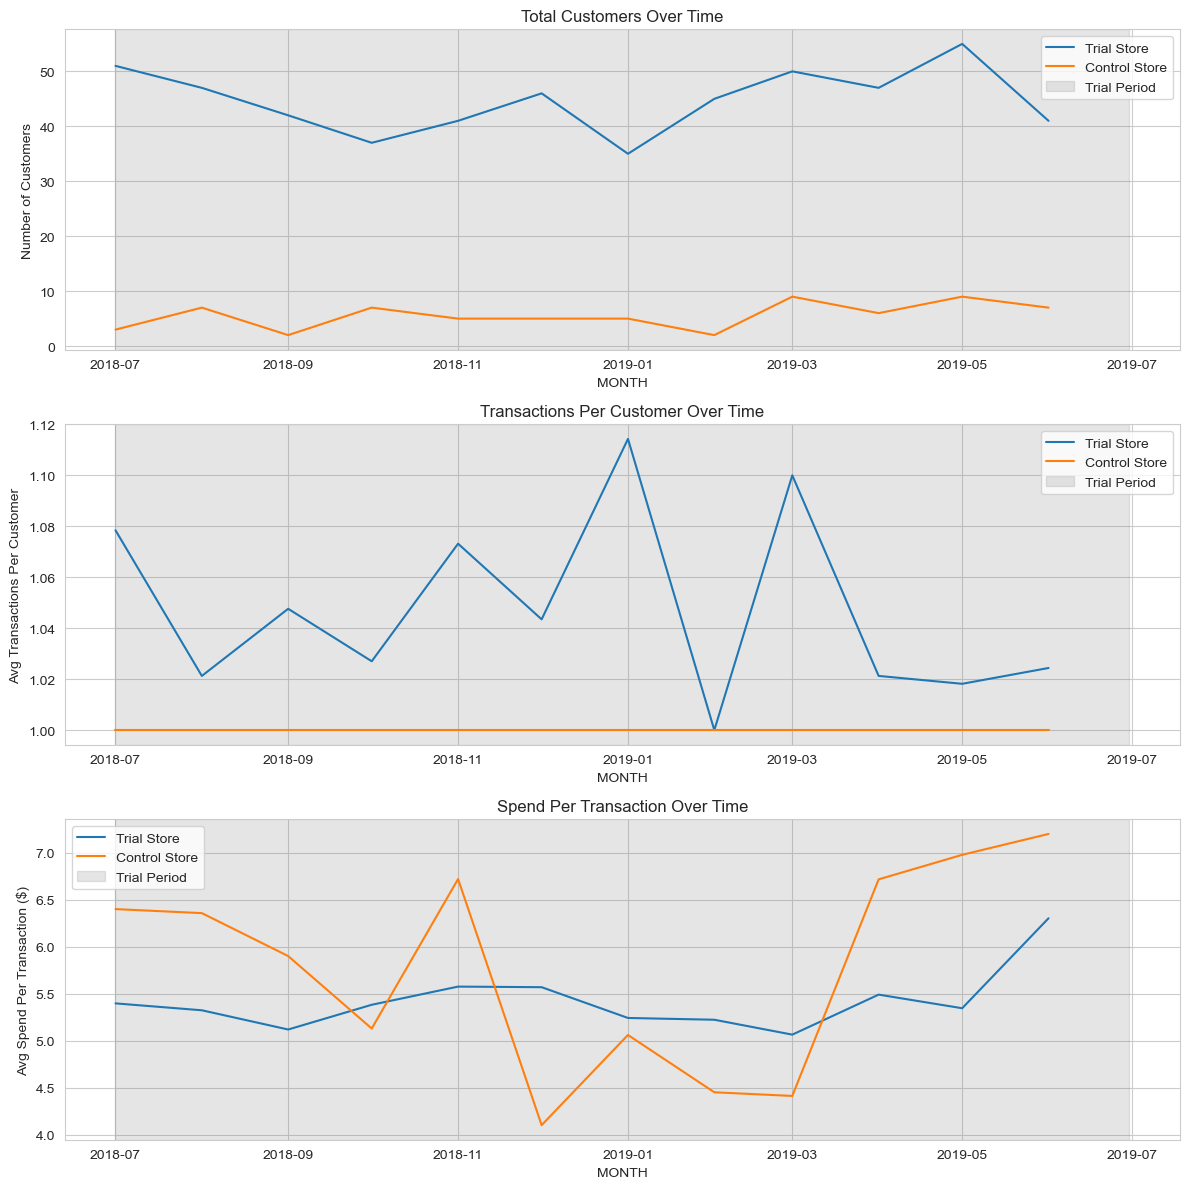


📌 Evaluating Trial Store 86 vs Control Store 224
Sales Impact Analysis
More Customers? Yes (p=0.00000)
More Transactions per Customer? No (p=1.00000)
Higher Spend per Transaction? No (p=0.10102)


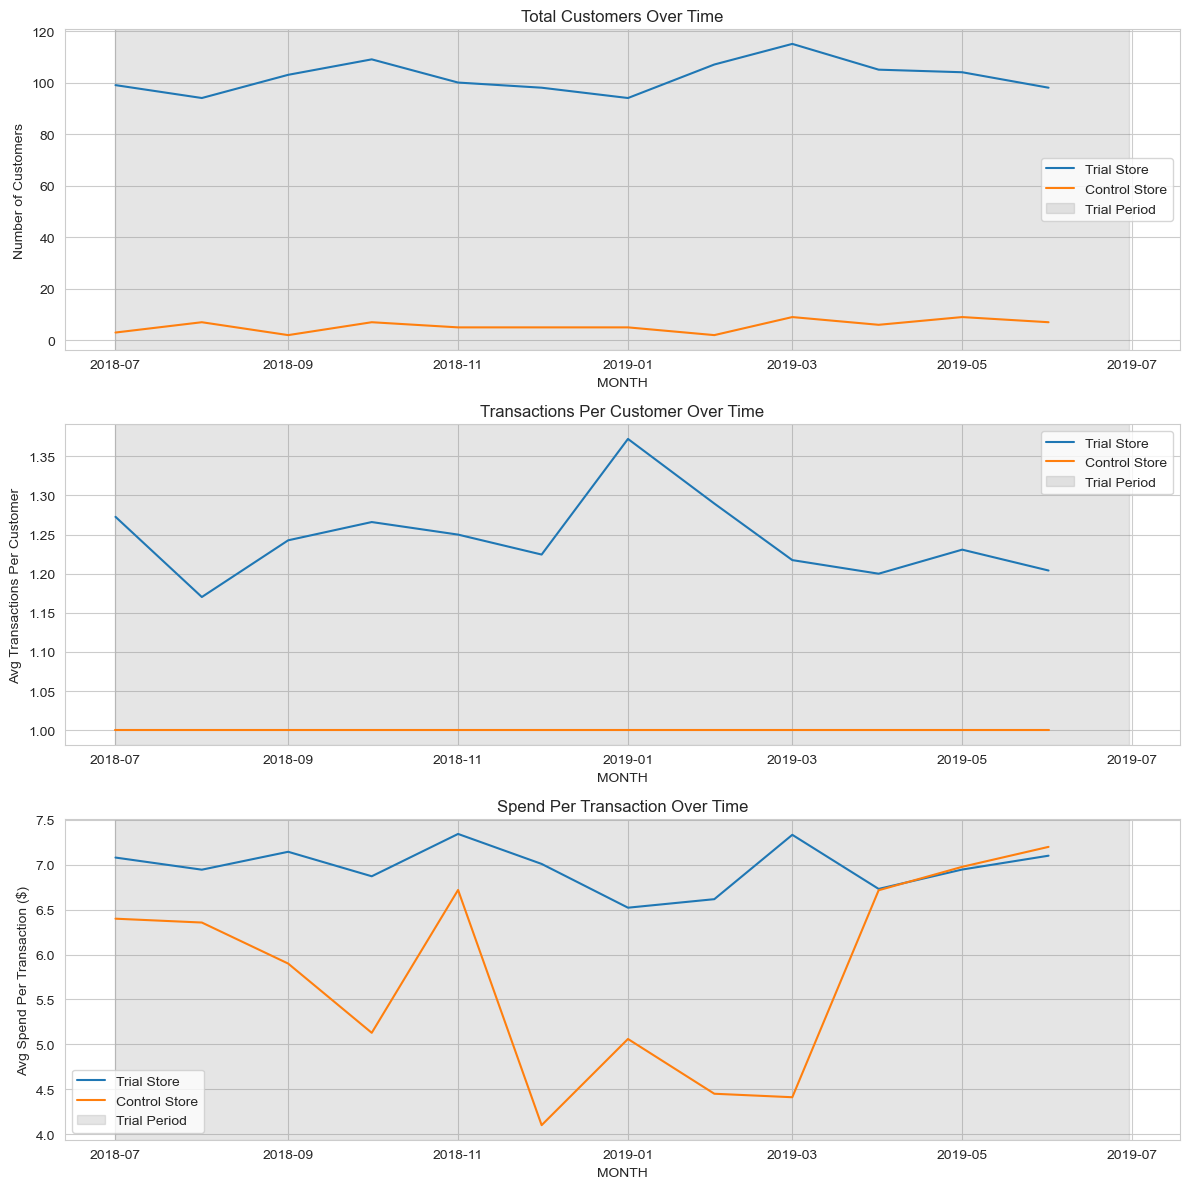


📌 Evaluating Trial Store 88 vs Control Store 224
Sales Impact Analysis
More Customers? Yes (p=0.00000)
More Transactions per Customer? No (p=1.00000)
Higher Spend per Transaction? Yes (p=0.00205)


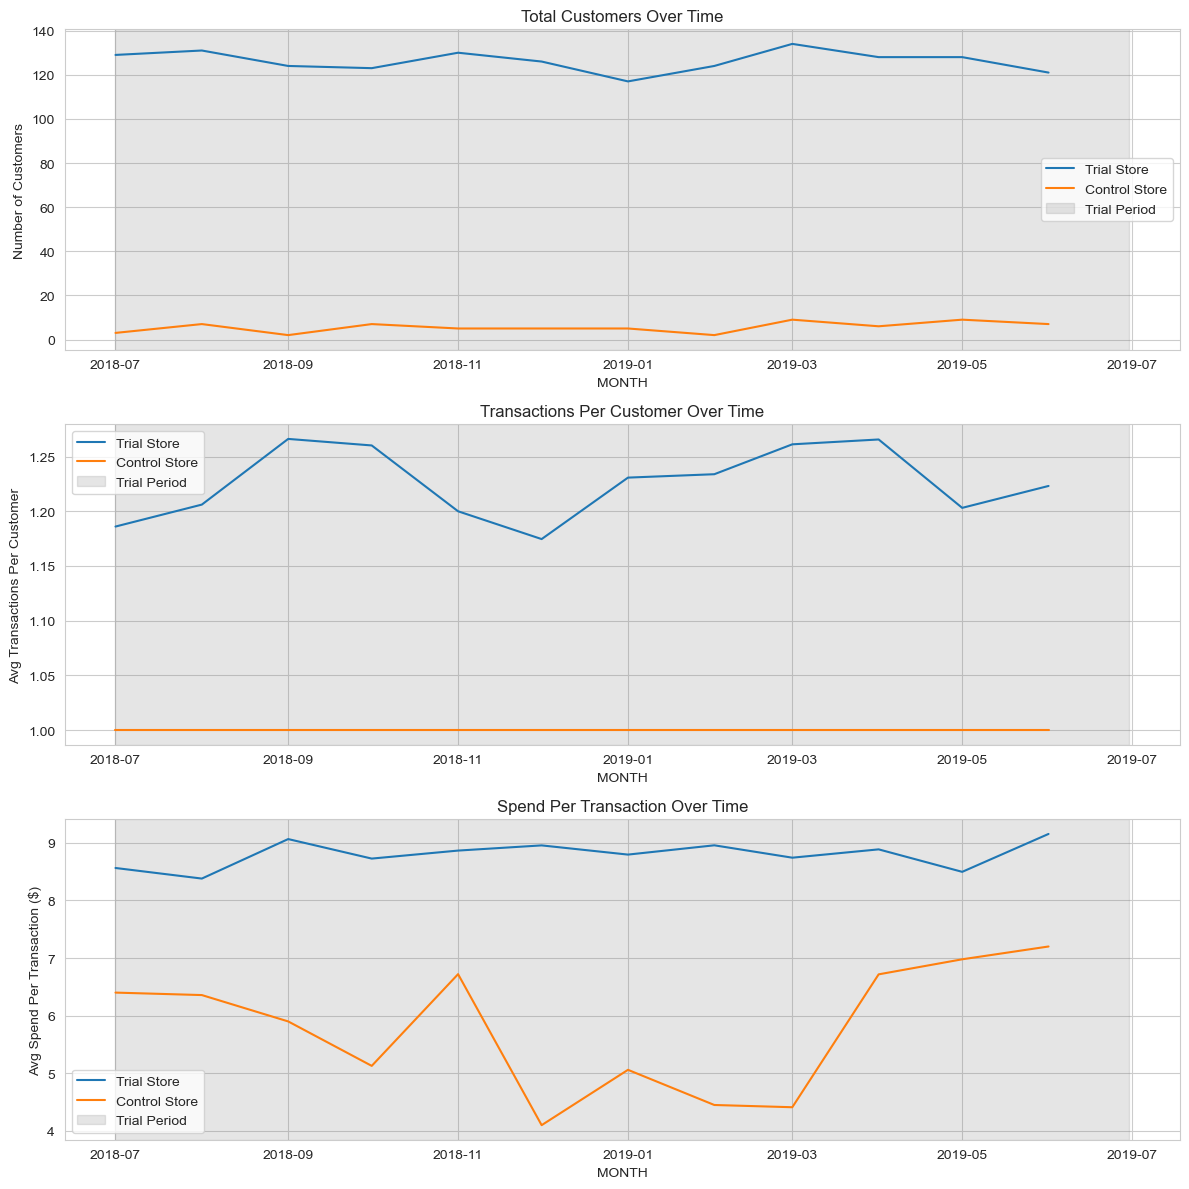

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import ttest_ind

def analyze_sales_difference(df, trial_store, control_store, trial_start, trial_end):
    """Analyzes whether sales differences are due to more customers, more transactions per customer, or higher spend per transaction."""
    
    # Fix: Convert Period to Timestamp before datetime conversion
    df['MONTH'] = pd.to_datetime(df['MONTH'].astype(str), dayfirst=True)

    # Ensure numeric columns
    numeric_cols = ['total_customers', 'avg_transactions_per_customer', 'avg_spend_per_transaction']
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

    trial_start = pd.to_datetime(trial_start, dayfirst=True)
    trial_end = pd.to_datetime(trial_end, dayfirst=True)

    trial_period = (df['MONTH'] >= trial_start) & (df['MONTH'] <= trial_end)

    trial_data = df[(df['STORE_NBR'] == trial_store) & trial_period]
    control_data = df[(df['STORE_NBR'] == control_store) & trial_period]

    # Function to safely run t-tests (Indented inside the function)
    def safe_ttest(trial_values, control_values):
        if trial_values.nunique() <= 1 or control_values.nunique() <= 1:
            return None, 1.0  # Return p=1.0 if no variation in data
        return ttest_ind(trial_values.dropna(), control_values.dropna(), equal_var=False)

    # Perform T-tests with safety check
    customers_t, customers_p = safe_ttest(trial_data['total_customers'], control_data['total_customers'])
    transactions_t, transactions_p = safe_ttest(trial_data['avg_transactions_per_customer'], control_data['avg_transactions_per_customer'])
    spend_t, spend_p = safe_ttest(trial_data['avg_spend_per_transaction'], control_data['avg_spend_per_transaction'])

    # Display results
    print("Sales Impact Analysis")
    print(f"More Customers? {'Yes' if customers_p < 0.05 else 'No'} (p={customers_p:.5f})")
    print(f"More Transactions per Customer? {'Yes' if transactions_p < 0.05 else 'No'} (p={transactions_p:.5f})")
    print(f"Higher Spend per Transaction? {'Yes' if spend_p < 0.05 else 'No'} (p={spend_p:.5f})")


def plot_sales_drivers(df, trial_store, control_store, trial_start, trial_end):
    """Generates visual comparisons of customers, transactions, and spending."""
    
    # Fix: Convert Period to Timestamp before datetime conversion
    df['MONTH'] = pd.to_datetime(df['MONTH'].astype(str), dayfirst=True)

    trial_data = df[df['STORE_NBR'] == trial_store]
    control_data = df[df['STORE_NBR'] == control_store]

    trial_start = pd.to_datetime(trial_start, dayfirst=True)
    trial_end = pd.to_datetime(trial_end, dayfirst=True)

    sns.set_style("whitegrid")
    
    fig, axes = plt.subplots(3, 1, figsize=(12, 12))

    # 1. Customers Over Time
    sns.lineplot(x=trial_data['MONTH'], y=trial_data['total_customers'], label='Trial Store', ax=axes[0])
    sns.lineplot(x=control_data['MONTH'], y=control_data['total_customers'], label='Control Store', ax=axes[0])
    axes[0].axvspan(trial_start, trial_end, color='gray', alpha=0.2, label="Trial Period")
    axes[0].set_title("Total Customers Over Time")
    axes[0].set_ylabel("Number of Customers")
    axes[0].legend()

    # 2. Transactions Per Customer
    sns.lineplot(x=trial_data['MONTH'], y=trial_data['avg_transactions_per_customer'], label='Trial Store', ax=axes[1])
    sns.lineplot(x=control_data['MONTH'], y=control_data['avg_transactions_per_customer'], label='Control Store', ax=axes[1])
    axes[1].axvspan(trial_start, trial_end, color='gray', alpha=0.2, label="Trial Period")
    axes[1].set_title("Transactions Per Customer Over Time")
    axes[1].set_ylabel("Avg Transactions Per Customer")
    axes[1].legend()

    # 3. Spend Per Transaction
    sns.lineplot(x=trial_data['MONTH'], y=trial_data['avg_spend_per_transaction'], label='Trial Store', ax=axes[2])
    sns.lineplot(x=control_data['MONTH'], y=control_data['avg_spend_per_transaction'], label='Control Store', ax=axes[2])
    axes[2].axvspan(trial_start, trial_end, color='gray', alpha=0.2, label="Trial Period")
    axes[2].set_title("Spend Per Transaction Over Time")
    axes[2].set_ylabel("Avg Spend Per Transaction ($)")
    axes[2].legend()

    plt.tight_layout()
    plt.show()

# Define trial stores
trial_stores = [77, 86, 88]
control_store = 224  # Single control store for all trials
trial_start, trial_end = '01/07/2018', '30/06/2019'  # Trial period (dd/mm/yyyy format)

# Loop through each trial store
for trial_store in trial_stores:
    print("\n" + "=" * 50)
    print(f"📌 Evaluating Trial Store {trial_store} vs Control Store {control_store}")
    print("=" * 50)

    # Perform statistical test
    analyze_sales_difference(df, trial_store, control_store, trial_start, trial_end)

    # Plot visual trends
    plot_sales_drivers(df, trial_store, control_store, trial_start, trial_end)

